In [379]:
import pandas as pd
import os
#parent_directory = os.path.dirname(os.getcwd())
#os.chdir(parent_directory)
print(os.getcwd())
# Load the CSV into a DataFrame
breast_cancer = pd.read_csv('data/Breast_Cancer.csv', header=0, delimiter=',')

# Check the shape of the DataFrame
print("Shape of the DataFrame:", breast_cancer.shape)


c:\Users\JaIk194\Documents\Master\Q2\ML\Project\BreastCancerClassification
Shape of the DataFrame: (4024, 16)


## Preprocessing

In [380]:
# remove spaces and symbols to avoid problems with statsmodel GLM
breast_cancer.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in breast_cancer.columns] 

# change the type of categorical variables into category
categorical_columns = list(breast_cancer.dtypes[breast_cancer.dtypes == 'O'].index.values)
for column in categorical_columns:
    breast_cancer[column] = breast_cancer[column].astype('category')

In [381]:
# change the type of categorical variables into category
categorical_columns = list(breast_cancer.dtypes[breast_cancer.dtypes == 'O'].index.values)
for column in categorical_columns:
    breast_cancer[column] = breast_cancer[column].astype('category')
# Define the custom order for each categorical variable
t_stage_order = ['T1', 'T2', 'T3', 'T4']
n_stage_order = ['N1', 'N2', 'N3']
stage_6_order = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']
differentiate_order = ['Undifferentiated', 'Poorly differentiated', 'Moderately differentiated', 'Well differentiated']


# Apply the custom order to the categorical variables
breast_cancer['t_stage'] = pd.Categorical(breast_cancer['t_stage'], categories=t_stage_order, ordered=True)
breast_cancer['n_stage'] = pd.Categorical(breast_cancer['n_stage'], categories=n_stage_order, ordered=True)
breast_cancer['6th_stage'] = pd.Categorical(breast_cancer['6th_stage'], categories=stage_6_order, ordered=True)
breast_cancer['differentiate'] = pd.Categorical(breast_cancer['differentiate'], categories=differentiate_order, ordered=True)

# Convert to numeric codes
breast_cancer['t_stage'] = breast_cancer['t_stage'].cat.codes
breast_cancer['n_stage'] = breast_cancer['n_stage'].cat.codes
breast_cancer['6th_stage'] = breast_cancer['6th_stage'].cat.codes
breast_cancer['differentiate'] = breast_cancer['differentiate'].cat.codes

# Eliminate columns   
breast_cancer = breast_cancer.drop(columns=['grade'])

### Balance the Dataset

In [382]:
breast_cancer = breast_cancer.sort_values(by='status', ascending=False)
breast_cancer = breast_cancer.iloc[:1500, :]
# Randomize the order of the dataframe
breast_cancer = breast_cancer.sample(frac=1).reset_index(drop=True)

In [383]:
print(breast_cancer['status'].value_counts())

status
Alive    884
Dead     616
Name: count, dtype: int64


### Feature Extraction

In [384]:
# Feature Extraction
#breast_cancer['survival_50'] = breast_cancer['survival_months'].apply(lambda x: 1 if x >= 50 else 0)
#breast_cancer = breast_cancer.drop(columns=['survival_months'])

breast_cancer['node_ratio'] = (breast_cancer['regional_node_positive']+0.1)/(breast_cancer['regional_node_examined']+0.1)
breast_cancer = breast_cancer.drop(columns=['regional_node_examined'])


In [385]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  1500 non-null   int64   
 1   race                 1500 non-null   category
 2   marital_status       1500 non-null   category
 3   t_stage              1500 non-null   int8    
 4   n_stage              1500 non-null   int8    
 5   6th_stage            1500 non-null   int8    
 6   differentiate        1500 non-null   int8    
 7   a_stage              1500 non-null   category
 8   tumor_size           1500 non-null   int64   
 9   estrogen_status      1500 non-null   category
 10  progesterone_status  1500 non-null   category
 11  survival_months      1500 non-null   int64   
 12  status               1500 non-null   category
 13  node_ratio           1500 non-null   float64 
 14  node_positive        1500 non-null   int64   
dtypes: category(6), float

In [386]:
breast_cancer.head()

,age,race,marital_status,t_stage,n_stage,6th_stage,differentiate,a_stage,tumor_size,estrogen_status,progesterone_status,survival_months,status,node_ratio,node_positive
0,63,White,Married,0,0,0,1,Regional,20,Positive,Positive,104,Alive,0.180328,1
1,65,White,Widowed,1,1,2,2,Regional,21,Positive,Positive,72,Dead,0.337017,1
2,47,White,Divorced,0,0,0,1,Regional,15,Positive,Positive,56,Dead,0.268293,1
3,52,White,Divorced,1,0,1,2,Regional,35,Positive,Positive,93,Alive,0.577465,1
4,55,White,Single,0,0,0,3,Regional,3,Positive,Negative,105,Alive,0.354839,1


In [387]:
#breast_cancer = breast_cancer.drop(["regional_node_examined", "regional_node_positive", "a_stage", "estrogen_status", "progesterone_status"], axis=1)

breast_cancer.shape

(1500, 15)

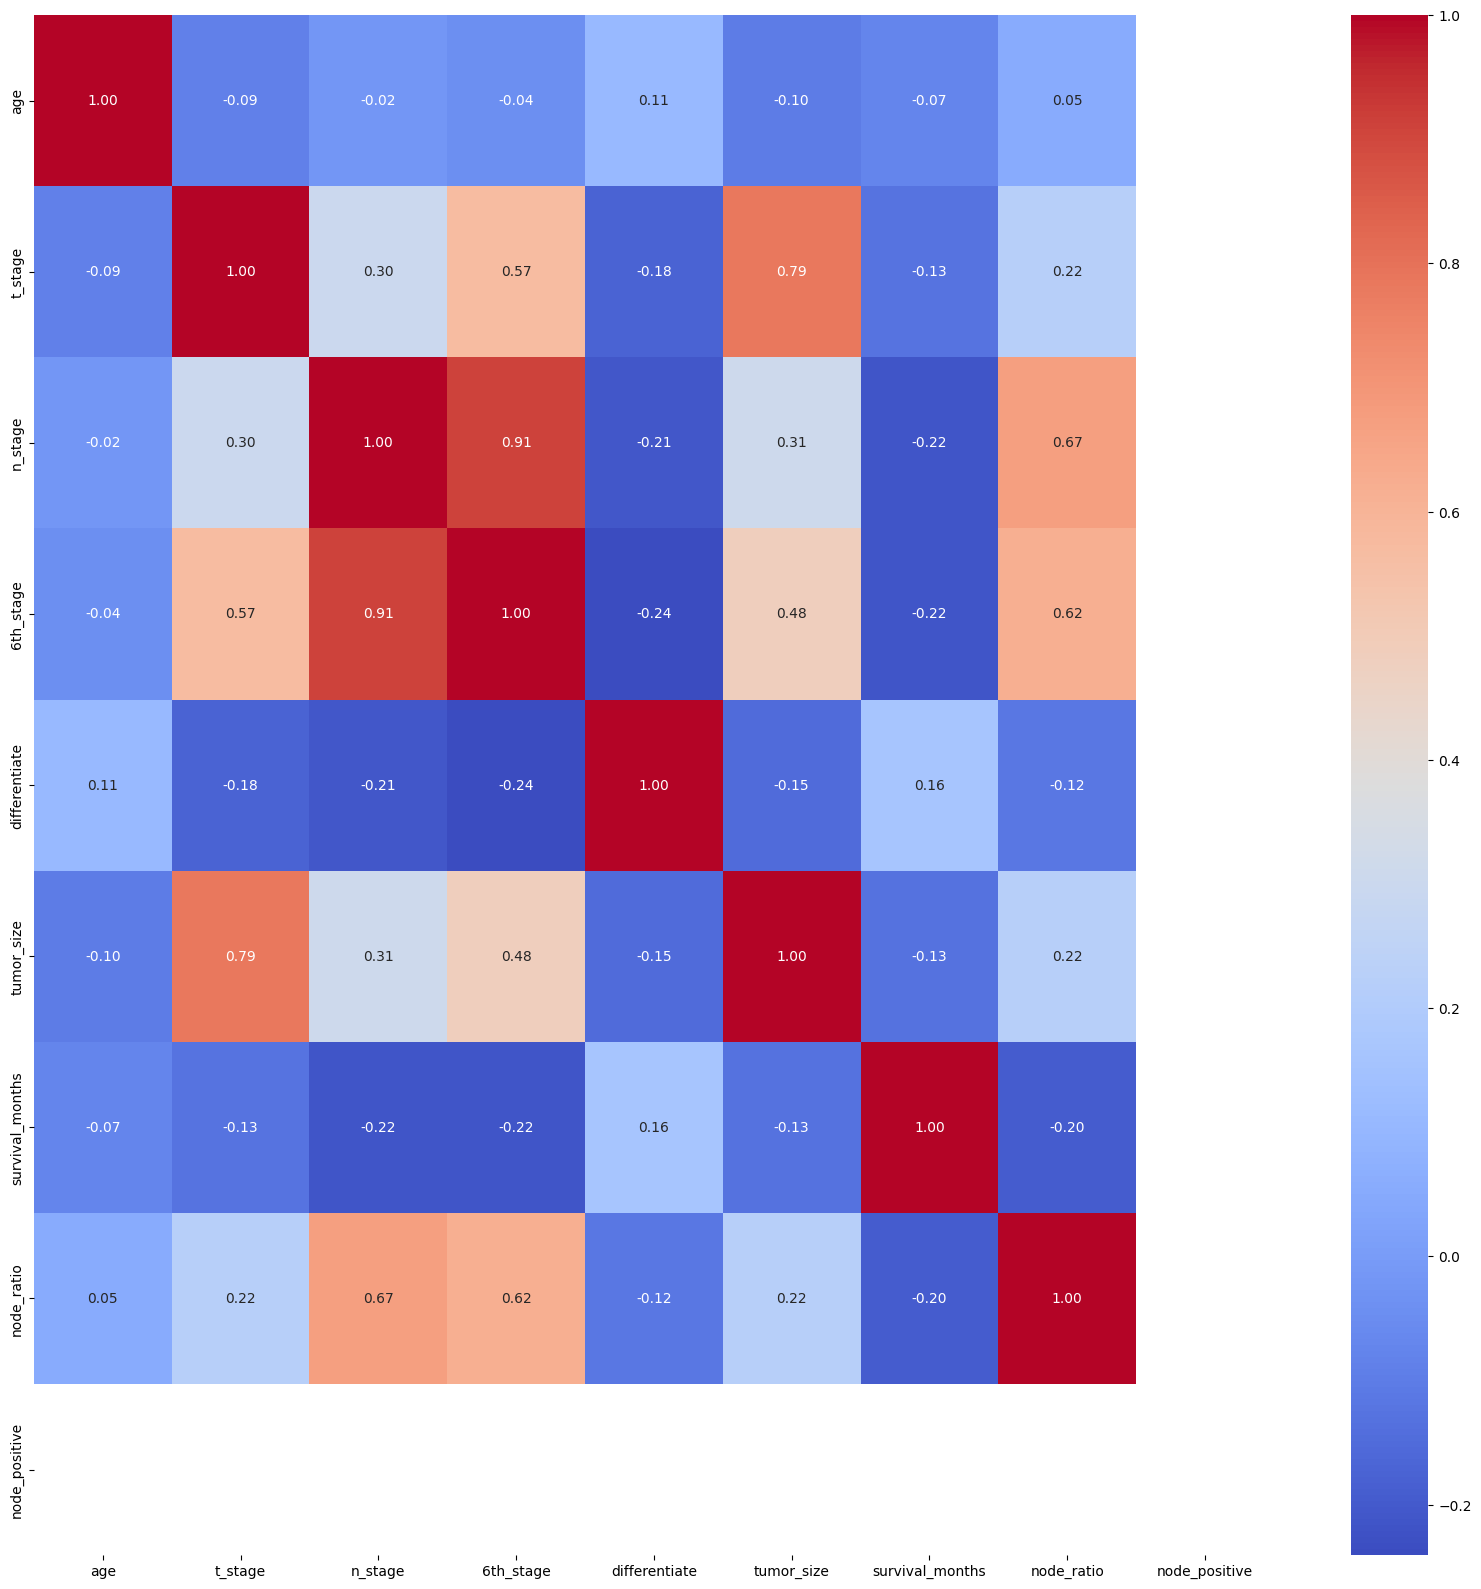

In [388]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = list(breast_cancer.dtypes[breast_cancer.dtypes != 'category'].index.values)
breast_cancer_numeric = breast_cancer[numeric_columns]
plt.figure(figsize=(20, 20))
sns.heatmap(breast_cancer_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [389]:
# Drop n_stage due to high correlation
#breast_cancer = breast_cancer.drop(columns=['n_stage'])

### Dataset Splits

In [390]:
from sklearn.model_selection import train_test_split

X = breast_cancer.loc[:, breast_cancer.columns != 'status']
y = breast_cancer['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [391]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def preprocessing(X, y, scaler=None):
    print('Original shape:{}'.format(X.shape))
    categorical_columns =X.dtypes[X.dtypes == 'category'].index.values
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    
    # Scale numerical variables
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        #scaler = StandardScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    # Apply one hot encoding to categorical variables
    for column in categorical_columns:
        X_one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.merge(X_one_hot,left_index=True,right_index=True)
        X = X.drop(columns=[column])
    
    # Drop missings
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


X_train, y_train, scaler = preprocessing(X_train,y_train)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)



Original shape:(1200, 14)
New shape:(1200, 23)
Original shape:(300, 14)
New shape:(300, 23)


In [392]:
#!pip install imblearn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler

np.random.seed(42)

# Apply Oversampling to balance the dataset


# Define the models and their hyperparameter grids
logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='multinomial')
logreg.fit(X_train, y_train)
avg_crossval_scores = logreg.scores_['Dead'].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]

models = {
    'Logistic Regression': (LogisticRegression(C=best_C), {'penalty': ['l1', 'l2'], 'C': [1, 10],'class_weight': [None,'balanced'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'class_weight': ['balanced']}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001],}),
    'Random Forest': (RandomForestClassifier(), {'criterion': ['gini', 'entropy', 'log_loss'],'n_estimators': [100, 200, 300], 'max_depth': [5, 10],'class_weight': [None, 'balanced']}),  
}

# Define a custom scoring function to calculate precision, recall, F1-score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='Dead'),
    'recall': make_scorer(recall_score, pos_label='Dead'),
    'f1_score': make_scorer(f1_score, pos_label='Dead')
}

# Perform cross-validation and hyperparameter tuning for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='f1_score')
    grid_search.fit(X_train, y_train)
    #grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the mean cross-validated scores for each metric
    cv_results = grid_search.cv_results_
    mean_scores = {
        'Precision': cv_results['mean_test_precision'][grid_search.best_index_],
        'Recall': cv_results['mean_test_recall'][grid_search.best_index_],
        'F1-score': cv_results['mean_test_f1_score'][grid_search.best_index_]
    }
    
    results[model_name] = {
        'Best Hyperparameters': grid_search.best_params_,
        **mean_scores,
        'Validation Errors': cv_results['std_test_accuracy'][grid_search.best_index_]
    }

# Create a dataframe to store the results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'


C:\Users\JaIk194\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JaIk194\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JaIk194\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497

In [393]:
df_results['Best Hyperparameters']['Logistic Regression']

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

In [394]:
df_results

,Best Hyperparameters,Precision,Recall,F1-score,Validation Errors
Model,,,,,
Logistic Regression,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.758402,0.78491,0.77086,0.021731
SVM,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.768323,0.750361,0.758088,0.014191
Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.813083,0.693548,0.747345,0.027889
Random Forest,"{'class_weight': 'balanced', 'criterion': 'gin...",0.797033,0.719955,0.755488,0.014767


### Logistic regression

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

best_lr_results = df_results['Best Hyperparameters']['Logistic Regression']
best_lr_model = LogisticRegression(**best_lr_results)
best_lr_model.fit(X_train, y_train)
y_pred = best_lr_model.predict(X_test)
# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Dead')
recall = recall_score(y_test, y_pred, pos_label='Dead')
f1 = f1_score(y_test, y_pred, pos_label='Dead')
confusion_mat = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Alive', 'Dead']

# Create a labeled confusion matrix with indicators
confusion_mat_labeled = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)
confusion_mat_labeled.index.name = 'True Value'
confusion_mat_labeled.columns.name = 'Predicted Value'

# Print the performance metrics and labeled confusion matrix
print("Random Forest Classifier - Test Results")
print("---------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("---------------------------------")
print("Confusion Matrix:")
print(confusion_mat_labeled)


# Plot the labeled confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_labeled, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


Random Forest Classifier - Test Results
---------------------------------
Accuracy: 0.9031
Precision: 0.9257
Recall: 0.9635
F1-score: 0.9442
---------------------------------
Confusion Matrix:
Predicted Value  Alive  Dead
True Value                  
Alive              660    25
Dead                53    67


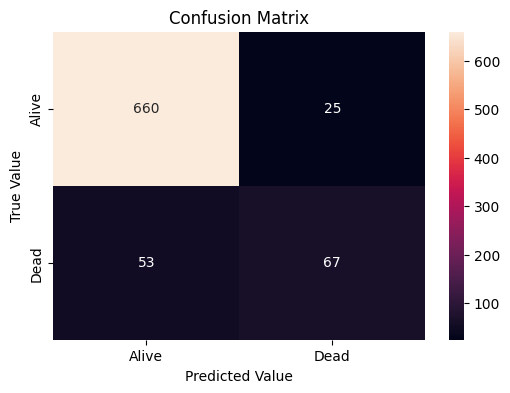

In [70]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Define the best hyperparameters for Random Forest
best_rf_params = {'class_weight': 'balanced','max_depth': 10, 'n_estimators': 200}

# Create and fit the best Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params)

# Fit the model and obtain the training and validation loss
best_rf_model.fit(X_train, y_train)
#best_rf_model.fit(X_train_resampled, y_train_resampled)
# Use the fitted model to make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Dead')
recall = recall_score(y_test, y_pred, pos_label='Dead')
f1 = f1_score(y_test, y_pred, pos_label='Dead')
confusion_mat = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Alive', 'Dead']

# Create a labeled confusion matrix with indicators
confusion_mat_labeled = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)
confusion_mat_labeled.index.name = 'True Value'
confusion_mat_labeled.columns.name = 'Predicted Value'

# Print the performance metrics and labeled confusion matrix
print("Random Forest Classifier - Test Results")
print("---------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("---------------------------------")
print("Confusion Matrix:")
print(confusion_mat_labeled)


# Plot the labeled confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_labeled, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


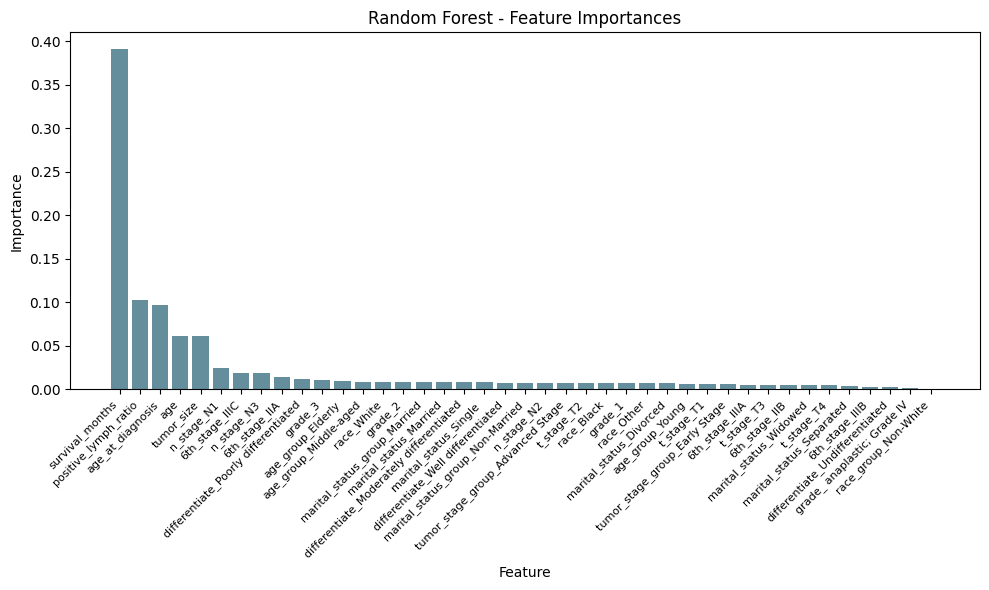

In [45]:
# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Get the names of the features
feature_names = X_train.columns[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, color='#648E9C')
plt.xticks(range(len(feature_importances)), feature_names, rotation=45, ha='right', fontsize=8)
plt.title('Random Forest - Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show();